In [32]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageEnhance, Image

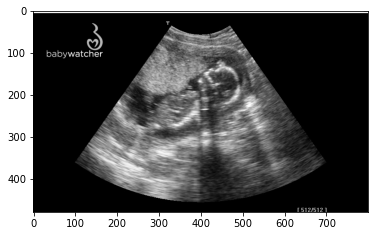

In [33]:
img = cv2.imread('Images/ultra1.png', 0)
plt.imshow(img, cmap='gray')

# I. Apply Image pre-processing/filtering
### 1. Crop outside part of image

Original shape (480, 800) 
New Shape (416, 536)


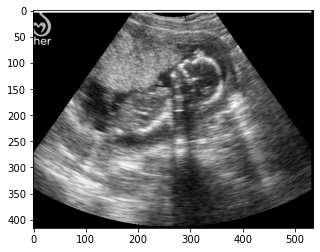

In [34]:
# to_crop = 2D grayscale image array
# threshold = [0-1] maximum 0s in row/col
# Removes parts of to_crop that have less than *threshold* information and pads array to shape divisible 8
def crop_low_info(to_crop, threshold):
    cropped = pd.DataFrame(to_crop)
    cropped = cropped.replace([0],np.nan)
    cropped = cropped.dropna(thresh=cropped.shape[0]*threshold,how='all',axis=1)
    cropped = cropped.dropna(thresh=cropped.shape[0]*threshold,how='all',axis=0)
    cropped = cropped.replace(np.nan,0).astype(np.uint8)
    cropped = np.pad(cropped, [(0, 8-cropped.shape[0]%8), (0, 8-cropped.shape[1]%8)], mode='constant', constant_values=0)
    return cropped


cropped = crop_low_info(img, 0.2)
print('Original shape {} \nNew Shape {}'.format(img.shape,cropped.shape))
plt.imshow(cropped, cmap='gray')

### 2. Apply filters

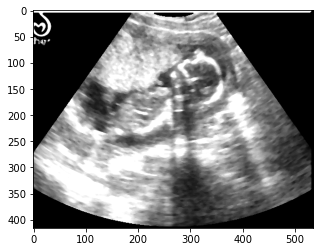

In [35]:
# Adjust brightness
def brighten(to_brighten, amount):
    to_brighten = Image.fromarray(to_brighten)
    converter = ImageEnhance.Brightness(to_brighten)
    return np.asarray(converter.enhance(amount))

def sharpen(to_sharpen, amount):
    to_sharpen = Image.fromarray(to_sharpen)
    converter = ImageEnhance.Sharpness(to_sharpen)
    return np.asarray(converter.enhance(amount))
  
def blur(to_blur, size):
    return cv2.medianBlur(to_blur, size)

def apply_filters(image, brighten_strength, median_size, sharpen_strength, steps=False):
    bright = brighten(cropped, brighten_strength)
    median = blur(bright, median_size)
    sharp = sharpen(median, sharpen_strength)
    return (bright, median, sharp) if steps else sharp


filtered = apply_filters(cropped,1.5,5,2, steps=False)
plt.imshow(filtered, cmap='gray')

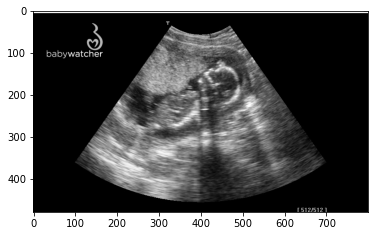

In [36]:
# For comparison (can't show side by side because sizes differ)
plt.imshow(img, cmap='gray')

### 3. Whole pre-processing pipeline

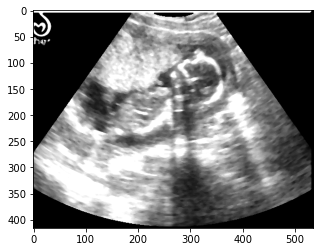

In [37]:
# Already filled in with magic variables. None of these are set
def pre_process(img):
    cropped = crop_low_info(img, 0.4)
    filtered = apply_filters(cropped, brighten_strength = 1.5, median_size = 5, sharpen_strength = 2, steps=False)
    return filtered

processed = pre_process(img)
plt.imshow(processed,cmap='gray')

# II. Feature recognition pipeline


### 1. Slide different size window over image
Make all sliding windows square. Including for long features (e.g spine, legs, arms)

<i> NOTE: make sure to associate each window with a (x, y, size) </i>

# TODO VECTORIZE THIS ASAP

In [38]:
%%time
# Input image and window_size
# Returns list of window_size sub-section of whole image
def get_window_coords(x, y, size):
    return np.ix_(np.arange(x, x+size),np.arange(y, y+size))

def get_windows(image, window_size, win_stride = 1):
    # x, y and size are int
    # window is list/np array
    windows = []
    coords = []
    for x in range(0, image.shape[0]-window_size+1, win_stride):
        for y in range(0, image.shape[1]-window_size+1, win_stride):
            window = image[get_window_coords(x, y, window_size)]
            
            coords.append([len(windows), x, y])
            windows.append(window)
            
    return windows, coords


windows, coords = get_windows(processed, 64, win_stride = 16)
print('{} windows were made'.format(len(windows)))

690 windows were made
CPU times: user 34.3 ms, sys: 7.49 ms, total: 41.8 ms
Wall time: 39.6 ms


In [39]:
def show_video(frames):
    i = 0
    while(True):
        gray = frames[i]
        i = (i+1)%len(frames)
        cv2.imshow('frame',gray)
        k = cv2.waitKey(2000)
        if k == 27:         # If escape was pressed exit
            cv2.destroyAllWindows()
            break

#show_video(windows)

### 2. Apply HOG to all windows

- For each feature:  
    - For each window: 
        - Resize to (128, 128)
        - Apply HOG
        - Save HOG

<i> NOTE: make sure to associate each HOG with a (x, y, size) </i>
# TODO VECTORIZE THIS ASAP

In [41]:
%%time

def get_hogs(windows):
    hog = cv2.HOGDescriptor()
    hogs = []
    for window in windows:
        w = cv2.resize(window, (128, 128))
        hogs.append(hog.compute(w))
    return hogs

hogs = get_hogs(windows)
print('{} HOG features'.format(len(hogs[0])))

34020 HOG features
CPU times: user 398 ms, sys: 66.7 ms, total: 465 ms
Wall time: 487 ms


Pipeline up until know:

In [42]:
low_info = 0.4
bright_strength = 1.5
med_size = 5
sharp_strength = 2
win_size = 64
win_stride = 16

def pre_process(img):
    cropped = crop_low_info(img, low_info)
    filtered = apply_filters(cropped, bright_strength, med_size, sharp_strength, steps=False)
    return filtered

def hog_pipeline(image):
    processed = pre_process(image)
    windows, coords = get_windows(processed, win_size, win_stride)
    hogs = get_hogs(windows)
    return hogs, coords


### 4. Train Classifiers

In [46]:
import sklearn as sk
from sklearn import svm

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def train(feauture):
    images = load_images_from_folder('Images/'+feature)
    # Resize images to (128, 128)
    # Compute HOG of each resized image
    # Randomly insert 'nothing' HOGs in data
    svclassifier = SVC(kernel='linear')
    SVM = svm.LinearSVC()
    SVM.fit(hogs, [feature]*len(hogs))
    return {'feature': feature, 'classifier': SVM}

features = ['head'] #, 'spine', 'leg', 'arm', 'hand', 'foot']
classifier_df = pd.DataFrame(columns=['feature', 'classifier'])

for feature in features:
    classifier_df = classifier_df.append(train(feature))

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'head'

### 3. Run all HOG features through each pre-trained classfication model
Each feature will have an separate SVM so:
- For each HOG features
    - For each SVM
        - Get match strength of HOG to feature

Filter out matches below threshold and sort by match strength. Highest wins

Low amount of data and high number of features, so we need a classification model that has bias/low variance such as Linear SVM.

https://www.kdnuggets.com/2020/05/guide-choose-right-machine-learning-algorithm.html

<i> NOTE: make sure to associate each match with a (x, y, size) </i>

In [47]:
y_pred = svclassifier.predict(X_test)

NameError: name 'X_test' is not defined

### Pipeline

In [11]:
image = []
window_sizes = [10]
threshold = 0.6

for size in window_sizes:
    windows = get_windows(image, size)
    hogs = get_hog(windows)
    matches = run_svm(hogs)
    matches = matches[matches['match']<=threshold]
    matches = matches.sort_values(by='match', ascending=False)

matches

AttributeError: 'list' object has no attribute 'shape'